Device set to use cpu


[INFO] Downloading model file from: https://drive.google.com/uc?id=1mU9YVr99C7E5hdys5zPQa5FnvplV8jWv&export=download


Downloading...
From: https://drive.google.com/uc?id=1mU9YVr99C7E5hdys5zPQa5FnvplV8jWv&export=download
To: /content/lyric_classifier_model.pkl
100%|██████████| 1.40M/1.40M [00:00<00:00, 120MB/s]


[INFO] Model loaded successfully
Enter song title: I drink wine
Enter artist name: Adele
[INFO] Fetching lyrics for: I drink wine - Adele

[INFO] Lyrics preview:
How can one become so bounded by choices that somebody else makes?
How come we've both become a version of a person we don't even like?
We're in love with the world, but the world just wants to bring us down
By puttin' ideas in our heads that corrupt our hearts somehow

When I was a child, every sin...

[INFO] Final prompt: bounded choices, dont sacrifice, free love, like love, love, love world, negative, romantic
[INFO] Image saved to ./outputs/i_drink_wine_output.png


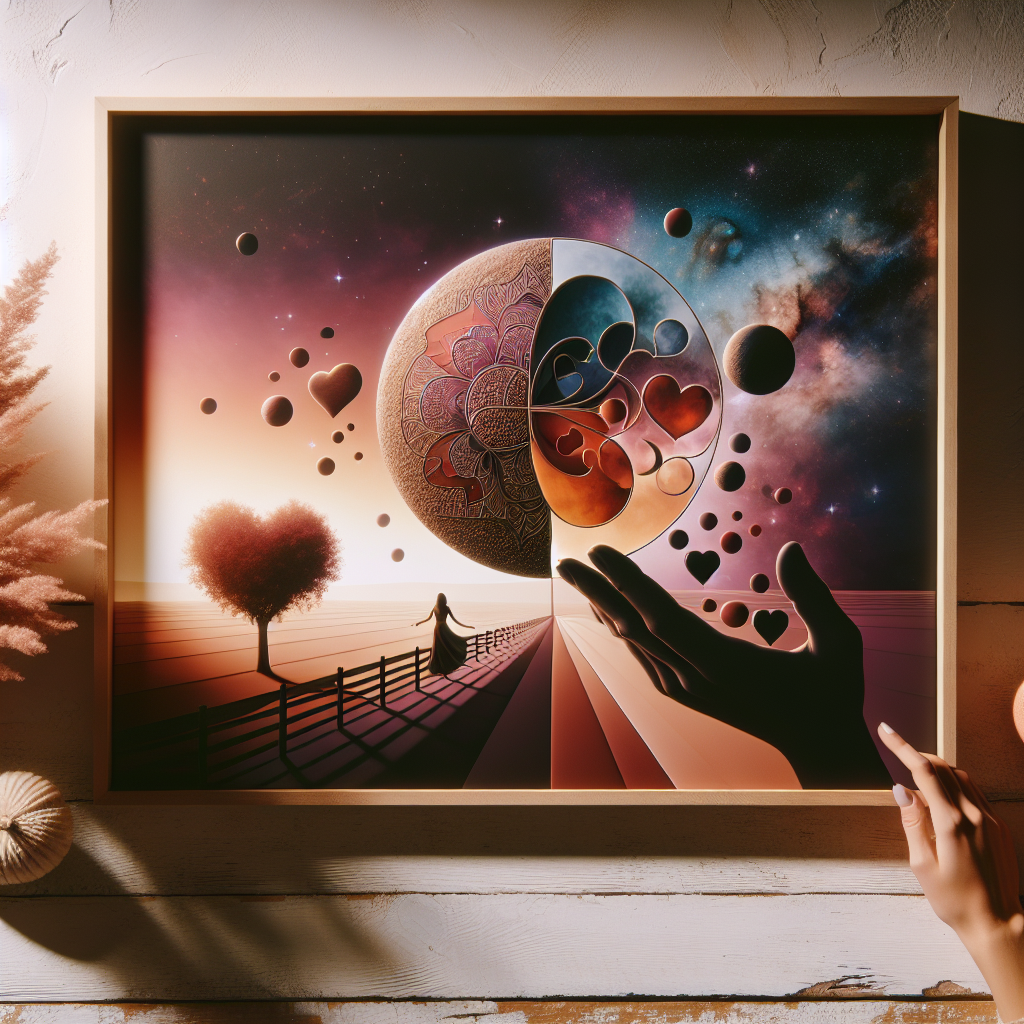

In [ ]:
# !pip install -U gdown keybert transformers openai

import os
import re
import requests
import openai
import joblib
import gdown
from keybert import KeyBERT
from transformers import pipeline as hf_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer

# CONFIGURATION
openai.api_key = "open_ai_key_here"  # Replace with your OpenAI API key
MUSIXMATCH_API_KEY = "musixmatch_api_key_here"  # Replace with your Musixmatch API key

# LOAD MODEL
def load_model(file_id="1mU9YVr99C7E5hdys5zPQa5FnvplV8jWv", out_path="./lyric_classifier_model.pkl"):
    url = f"https://drive.google.com/uc?id={file_id}&export=download"
    if os.path.exists(out_path):
        os.remove(out_path)
    print(f"[INFO] Downloading model file from: {url}")
    gdown.download(url=url, output=out_path, quiet=False, use_cookies=True)
    if os.path.getsize(out_path) < 100000:
        raise ValueError("Download failed: file too small, possibly HTML.")
    print("[INFO] Model loaded successfully")
    saved_model = joblib.load(out_path)
    return saved_model["pipeline"], saved_model["mlb"]

# TEXT & LYRICS UTILITIES
kw_model = KeyBERT()
sentiment_pipeline = hf_pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return " ".join([w for w in text.split() if len(w) > 2])

def get_lyrics(song_title, artist):
    print(f"[INFO] Fetching lyrics for: {song_title} - {artist}")
    url = "https://api.musixmatch.com/ws/1.1/matcher.lyrics.get"
    params = {
        "apikey": MUSIXMATCH_API_KEY,
        "q_track": song_title,
        "q_artist": artist
    }
    res = requests.get(url, params=params)
    data = res.json()
    try:
        full_lyrics = data['message']['body']['lyrics']['lyrics_body']
        return full_lyrics.split("...")[0].strip()
    except KeyError:
        return None

def predict_sentiment(text):
    result = sentiment_pipeline(text[:512])[0]
    return result['label'], result['score']

def extract_keywords(text, top_n=5):
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=top_n)
    return list({" ".join(sorted(set(k[0].split()))) for k in keywords})[:top_n]

def predict_tags(text, pipeline, mlb, energy=None, mode=None, threshold=0.1):
    tfidf_vec = pipeline.named_steps['tfidf'].transform([clean_text(text)])
    probas = pipeline.named_steps['clf'].predict_proba(tfidf_vec)
    final_tags = [mlb.classes_[i] for i, p in enumerate(probas) if p[0][1] >= threshold]

    # if energy is not None:
    #     if float(energy) > 0.7:
    #         final_tags.append("energetic")
    #     elif float(energy) < 0.3:
    #         final_tags.append("mellow")

    # if mode is not None:
    #     final_tags.append("major-key" if round(float(mode)) == 1 else "minor-key")

    return final_tags

# Calling open AI models
from openai import OpenAI
client = OpenAI(api_key=openai.api_key)

def generate_image(prompt, out_path="output.png"):
    response = client.images.generate(
        model="dall-e-3",
        prompt=prompt,
        n=1,
        size="1024x1024"
    )
    img_url = response.data[0].url
    img_data = requests.get(img_url).content
    with open(out_path, 'wb') as f:
        f.write(img_data)
    print(f"[INFO] Image saved to {out_path}")

# MAIN FUNCTION
def process_single_song(pipeline, mlb):
    song_title = input("Enter song title: ")
    artist = input("Enter artist name: ")

    lyrics = get_lyrics(song_title, artist)
    if not lyrics:
        print("[ERROR] Failed to fetch lyrics.")
        return

    print(f"\n[INFO] Lyrics preview:\n{lyrics[:300]}...\n")

    sentiment, score = predict_sentiment(lyrics)
    keywords = extract_keywords(clean_text(lyrics))
    tags = predict_tags(lyrics, pipeline, mlb, energy=None, mode=None)

    prompt = ", ".join(sorted(set(tags + keywords + [sentiment.lower()])))
    print(f"[INFO] Final prompt: {prompt}")

    os.makedirs("./outputs", exist_ok=True)
    out_path = f"./outputs/{song_title.lower().replace(' ', '_')}_output.png"
    generate_image(prompt, out_path=out_path)

    from IPython.display import Image, display
    display(Image(out_path))

# RUN
if __name__ == "__main__":
    model_file_id = "1mU9YVr99C7E5hdys5zPQa5FnvplV8jWv"
    pipeline, mlb = load_model(model_file_id)
    process_single_song(pipeline, mlb)
